# Build a RAG app

https://python.langchain.com/docs/tutorials/rag/

## Part I

In [1]:
# !pip install langchain-text-splitters langchain-community langgraph langchain mlx_lm langsmith

In [2]:
import getpass
import os

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = "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"

In [3]:
from langchain_community.llms.mlx_pipeline import MLXPipeline

llm = MLXPipeline.from_model_id(
    "mlx-community/Qwen2.5-32B-Instruct-4bit",
    pipeline_kwargs={"max_tokens": 4000, "temp": 0.1},
)

from langchain_community.chat_models.mlx import ChatMLX
model = ChatMLX(llm=llm)

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

In [4]:
# !pip install langchain_huggingface

In [5]:
from langchain_huggingface import HuggingFaceEmbeddings

# embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
embeddings = HuggingFaceEmbeddings(model_name="Alibaba-NLP/gte-Qwen2-1.5B-instruct")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
# !pip install -qU langchain-core

In [7]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

In [8]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [9]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

# Index chunks
_ = vector_store.add_documents(documents=all_splits)

In [11]:
from langchain import hub
# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")


from typing_extensions import List, TypedDict
from langgraph.graph import START, StateGraph
from langchain_core.documents import Document
# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = model.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

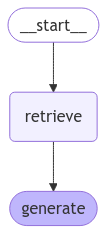

In [12]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
response = graph.invoke({"question": "What is Task Decomposition?"})
print(response["answer"])

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[Warning] Specifying sampling arguments to ``generate_step`` is deprecated. Pass in a ``sampler`` instead.
Task decomposition is the process of breaking down a complex task into smaller, more manageable subtasks. This can be achieved through various methods such as chain of thought (CoT) prompting, where tasks are decomposed into a series of steps, or by using task-specific instructions and human inputs.


In [14]:
for step in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='cbfe37a9-c5c8-41bd-b41d-105984a656f9', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'), Document(id='77c462f3-05a9-469e-b3cf-3b226a2eb0a8', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reaso

In [15]:
for message, metadata in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="messages"
):
    print(message.content, end="")

[Warning] Specifying sampling arguments to ``generate_step`` is deprecated. Pass in a ``sampler`` instead.
Task decomposition is the process of breaking down a complex task into smaller, more manageable subtasks. This can be achieved through various methods such as chain of thought (CoT) prompting, where tasks are decomposed into a series of steps, or by using task-specific instructions and human inputs.<|im_end|>

## Part II

https://python.langchain.com/docs/tutorials/qa_chat_history/